1. torchvision을 사용하여 CIFAR10의 학습용 데이터, 시험용 데이터 불러오기, 정규화
2. 합성곱 신경망 정의
3. 손실 함수 정의
4. 학습용 데이터를 사용하여 신경망 학습
5. 시험용 데이터를 사용하여 신경망 검사

In [1]:
#결과 inline에 출력
%matplotlib inline

In [2]:
import torch
import torchvision
from torchvision.datasets import CIFAR10
import torchvision.transforms as transforms
import collections
from sklearn import datasets
from imblearn import under_sampling
from typing import Any, Callable, Dict, List, Optional, Tuple
import os
import numpy as np

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
print(torch.cuda.device_count())

2


In [5]:
print(torch.__version__)

1.7.1+cu101


In [6]:
print(torchvision.__version__)

0.8.2+cu101


In [7]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [8]:
type(trainset.data)

numpy.ndarray

In [9]:
trainset.data.shape

(50000, 32, 32, 3)

In [10]:
trainset.data[0][0]

array([[ 59,  62,  63],
       [ 43,  46,  45],
       [ 50,  48,  43],
       [ 68,  54,  42],
       [ 98,  73,  52],
       [119,  91,  63],
       [139, 107,  75],
       [145, 110,  80],
       [149, 117,  89],
       [149, 120,  93],
       [131, 103,  77],
       [125,  99,  76],
       [142, 115,  91],
       [144, 112,  86],
       [137, 105,  79],
       [129,  97,  71],
       [137, 106,  79],
       [134, 106,  76],
       [124,  97,  64],
       [139, 113,  78],
       [139, 112,  75],
       [133, 105,  69],
       [136, 105,  74],
       [139, 108,  77],
       [152, 120,  89],
       [163, 131, 100],
       [168, 136, 108],
       [159, 129, 102],
       [158, 130, 104],
       [158, 132, 108],
       [152, 125, 102],
       [148, 124, 103]], dtype=uint8)

In [11]:
type(trainset.targets)

list

In [12]:
print('Original dataset shape %s' % collections.Counter(trainset.targets))


Original dataset shape Counter({6: 5000, 9: 5000, 4: 5000, 1: 5000, 2: 5000, 7: 5000, 8: 5000, 3: 5000, 5: 5000, 0: 5000})


In [13]:
class unbalance_CIFAR10(CIFAR10):
     def __init__(
            self,
            root: str,
            train: bool = True,
            transform: Optional[Callable] = None,
            target_transform: Optional[Callable] = None,
            download: bool = False,
    ) -> None:
        super(unbalance_CIFAR10, self).__init__(root, transform=transform,
                                    target_transform=target_transform)
        

     
        rus = under_sampling.RandomUnderSampler(
            sampling_strategy={
                0: 500,
                1: 5000,
                2: 500,
                3: 5000,
                4: 500,
                5: 5000,
                6: 500,
                7: 5000,
                8: 500,
                9: 5000
                
            },
            random_state=42
        )
        self.data, self.targets = rus.fit_resample(np.array(self.data).reshape(50000,32*32*3), np.array(self.targets))
#         self.data, self.targets = torch.Tensor(self.data.reshape(-1,32,32,3)).to(dtype=torch.uint8), torch.Tensor(self.targets).to(dtype=torch.uint8)
        self.data, self.targets = self.data.reshape(-1,32,32,3), self.targets



In [14]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5,), (0.5,))])

batch_size = 2048

trainset = unbalance_CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers= 8 ,pin_memory= True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=True, num_workers=8, pin_memory= True)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified


In [15]:
print('reshape dataset shape %s' % collections.Counter(trainset.targets.tolist()))

reshape dataset shape Counter({1: 5000, 3: 5000, 5: 5000, 7: 5000, 9: 5000, 0: 500, 2: 500, 4: 500, 6: 500, 8: 500})


In [16]:
type(trainset.data)

numpy.ndarray

In [17]:
type(testset.data)

numpy.ndarray

In [18]:
trainset.data.shape

(27500, 32, 32, 3)

In [19]:
type(trainset.targets)

numpy.ndarray

In [20]:
len(trainset.data)

27500

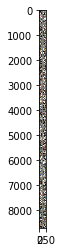

  dog   car   car truck


In [21]:
import matplotlib.pyplot as plt
import numpy as np

# 이미지를 보여주기 위한 함수

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# 학습용 이미지를 무작위로 가져오기
dataiter = iter(trainloader)
print(dataiter)
images, labels = dataiter.next()
# 이미지 보여주기
imshow(torchvision.utils.make_grid(images))
# 정답(label) 출력
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = torch.nn.Sequential(
          nn.Conv2d(3, 32, 3),
          nn.ReLU(),
          nn.Conv2d(32, 32, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )

        self.layer2 = torch.nn.Sequential(
          nn.Conv2d(32, 64, 3),
          nn.ReLU(),
          nn.Conv2d(64, 64, 3),
          nn.ReLU(),
          nn.MaxPool2d(2, 2),
          nn.Dropout(0.2)
        )


        self.fc1 = nn.Linear(1600, 120)
        self.bn1 = nn.BatchNorm1d(120)
        self.bn2 = nn.BatchNorm1d(84)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)


    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = torch.flatten(x, 1) # 배치를 제외한 모든 차원을 평탄화(flatten)
        x = F.relu(self.bn1(self.fc1(x)))
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x)
        return x


net = Net()

if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

net.to(device)

DataParallel(
  (module): Net(
    (layer1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (layer2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Dropout(p=0.2, inplace=False)
    )
    (fc1): Linear(in_features=1600, out_features=120, bias=True)
    (bn1): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm1d(84, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (fc2): Linear(in_features=120, out_features=84, bias=True)
    (fc3): Linear(in_feat

In [23]:
import torch.optim as optim

# criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [24]:
def custom_CE(output,labels):
    count_output = len(labels)
    loss_total = 0.0
    for i in range(count_output):
        loss = torch.log(sum(torch.exp(output[i]))) - output[i][labels[i]]
        loss_total += loss
    return loss_total/count_output

In [25]:
import time
start = time.time()  # 시작 시간 저장

In [26]:
net.train()
for epoch in range(200):   # 데이터셋을 수차례 반복합니다.
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # [inputs, labels]의 목록인 data로부터 입력을 받은 후;
        inputs, labels = data[0].to(device), data[1].to(device)

        # 변화도(Gradient) 매개변수를 0으로 만들고
        optimizer.zero_grad()

        # 순전파 + 역전파 + 최적화를 한 후
        outputs = net(inputs)
        loss = custom_CE(outputs, labels)
        loss.backward()
        optimizer.step()

        # 통계를 출력합니다.
        running_loss += loss.item()
        if i % 10 == 9:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 10))
            running_loss = 0.0

print('Finished Training')

[1,    10] loss: 1.933
[2,    10] loss: 1.356
[3,    10] loss: 1.153
[4,    10] loss: 1.026
[5,    10] loss: 0.939
[6,    10] loss: 0.866
[7,    10] loss: 0.811
[8,    10] loss: 0.759
[9,    10] loss: 0.711
[10,    10] loss: 0.660
[11,    10] loss: 0.632
[12,    10] loss: 0.586
[13,    10] loss: 0.547
[14,    10] loss: 0.518
[15,    10] loss: 0.491
[16,    10] loss: 0.461
[17,    10] loss: 0.435
[18,    10] loss: 0.413
[19,    10] loss: 0.399
[20,    10] loss: 0.372
[21,    10] loss: 0.351
[22,    10] loss: 0.340
[23,    10] loss: 0.308
[24,    10] loss: 0.296
[25,    10] loss: 0.277
[26,    10] loss: 0.254
[27,    10] loss: 0.251
[28,    10] loss: 0.243
[29,    10] loss: 0.234
[30,    10] loss: 0.222
[31,    10] loss: 0.210
[32,    10] loss: 0.194
[33,    10] loss: 0.184
[34,    10] loss: 0.175
[35,    10] loss: 0.166
[36,    10] loss: 0.153
[37,    10] loss: 0.153
[38,    10] loss: 0.149
[39,    10] loss: 0.137
[40,    10] loss: 0.143
[41,    10] loss: 0.128
[42,    10] loss: 0.124
[

In [27]:
print("time :", time.time() - start)  # 현재시각 - 시작시간 = 실행 시간

time : 3605.512553215027


In [28]:
# PATH = './fashion_net.pth'
# torch.save(net.state_dict(), PATH)

In [29]:
dataiter = iter(testloader)
images, labels = dataiter.next()
images = images.to(device)
labels = labels.to(device)
# 이미지를 출력합니다.
# imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(64)))

GroundTruth:   deer horse plane horse truck   cat   dog plane   dog plane  frog   dog   car   car  bird plane  bird  bird  frog  bird  deer horse horse truck  ship  frog   dog  bird  deer plane plane truck  ship  bird plane horse horse   dog horse plane  deer plane  ship  frog  frog  bird  ship  bird plane  deer   dog  deer truck   dog  deer plane horse plane  bird  deer  frog   dog  ship   dog


In [30]:
# net = Net()
# net.to(device)
# net.load_state_dict(torch.load(PATH))

In [31]:
net.train()
outputs = net(images)

In [32]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(batch_size)))

Predicted:   deer horse plane horse horse horse   dog plane   dog   car   cat   dog   car   car  frog truck   cat  bird  frog  bird horse horse   dog truck truck   dog   dog   dog   cat   car horse truck truck   cat   cat horse horse   cat horse horse   car plane  ship  frog   dog  bird  ship   dog plane horse   dog horse truck   dog horse plane horse   car   dog horse   cat horse  ship horse   dog truck  frog  frog   dog  ship truck   cat   car   car   cat  ship horse horse  ship plane   dog plane   car   car   cat truck  deer  frog truck   cat  deer   cat plane horse   car  ship horse  bird   cat  deer   car  deer plane truck horse horse   car horse   car   car   cat horse   dog plane   car   car   dog truck   car truck   car horse truck plane   car truck   cat   car horse   cat truck  ship horse   dog   car   dog   car   cat   car truck horse truck   car horse   cat   car horse   dog horse horse   car horse   car  bird  deer   cat   cat truck horse   dog   car   dog  deer truck   do

In [33]:
net.eval()
correct = 0
total = 0
# 학습 중이 아니므로, 출력에 대한 변화도를 계산할 필요가 없습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)

        # 신경망에 이미지를 통과시켜 출력을 계산합니다
        outputs = net(images)
        # 가장 높은 값(energy)를 갖는 분류(class)를 정답으로 선택하겠습니다
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 63 %


In [34]:
# 각 분류(class)에 대한 예측값 계산을 위해 준비
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# 변화도는 여전히 필요하지 않습니다
with torch.no_grad():
    for data in testloader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # 각 분류별로 올바른 예측 수를 모읍니다
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# 각 분류별 정확도(accuracy)를 출력합니다
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname,
                                                   accuracy))

Accuracy for class plane is: 52.3 %
Accuracy for class car   is: 90.9 %
Accuracy for class bird  is: 27.3 %
Accuracy for class cat   is: 66.2 %
Accuracy for class deer  is: 27.3 %
Accuracy for class dog   is: 79.1 %
Accuracy for class frog  is: 55.8 %
Accuracy for class horse is: 89.5 %
Accuracy for class ship  is: 55.0 %
Accuracy for class truck is: 89.7 %


In [35]:
for i in range(10):
    print(classes[labels[i]])

frog
truck
truck
horse
car
frog
horse
dog
frog
bird
